In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [2]:
#**************第一步：读文本数据数据**************

f = open('stock_list11.txt','r') 
a = f.read() 
stock_list = eval(a) 
f.close()

stock_data1_df = pd.read_csv("stock_data11.csv")
stock_data1 = dict()
stock_data1_df.index= pd.to_datetime(stock_data1_df.date)
del stock_data1_df['date']
for code in stock_data1_df.keys():
    stock_data1[code] = stock_data1_df[code].dropna()

In [3]:
#**************第二步：聚类**************

#下面用聚类来进行聚类分析
def dist(stock_a,stock_b):       
    return np.sqrt(np.sum(np.power(stock_a-stock_b,2)))

#随机设置初始中心
def randcent(dataset,k):
    n=np.shape(dataset)[1]
    centers=np.mat(np.zeros((k,n)))
    for j in range(n):
        Min=min(dataset[:,j])
        Max=max(dataset[:,j])
        centers[:,j]=Min+float(Max-Min)*np.random.rand(k,1)
    return centers

#判断是否点到各中心点的距离最近的那个点的位置
def ddist(d):
    for i in range(len(d)):
        if d[i]==d.min():dd=i
    return dd

#从stock_data中构造成文龙的dataset，array
dataset = []
dataset_dict = []
for ss_code in stock_data1.keys():
    dataset.append(np.array(stock_data1[ss_code]))
    dataset_dict.append(ss_code)
dataset = np.array(dataset)
for i in range(0,len(dataset[:,0])):
    dataset[i,:]=(dataset[i,:]-dataset[i,:].min())/(dataset[i,:].max()-dataset[i,:].min())

#############################下面进行聚类#############################
m=np.shape(dataset)[0] 
k=6                          #要分多少类即有多少个中心点
centers=randcent(dataset,k)
count=0
T=True                         #判断是否需要继续迭代下去
while T:
    clusters=[]                #记录每个点所属的类别
    centers_new=[]
    one_cluster=[]
    for i in range(m):
        d=[]                   #记录当前点到中心点的距离
        for j in range(k):
            d.append(dist(dataset[i,:],centers[j,:]))   
        clusters.append(ddist(np.array(d)))   #当前点离中心点记录最近的位置，这里就相当于记录了当前点的类别
    
    clusters=np.array(clusters)
    for i in range(k):
        one_cluster=[]
        for j in range(m):
            if clusters[j]==i:
                one_cluster.append(dataset[j,:])
        one_cluster=np.array(one_cluster)
        centers_new.append(pd.DataFrame(one_cluster).apply(sum)/one_cluster.shape[0])
    centers_new=np.array(centers_new)
    
    if (centers==centers_new).all():T=False
    else:centers=centers_new
    count=count+1                         #计算迭代了多少次然后使得聚类中心不再变
        
print(centers.shape)
#print(clusters)
print("迭代次数为%d"%count)
print("")
#######################显示出分类的类别##########################

print("以下为各只股票的聚类结果") 
f = open('cluster.txt','a')
for i in range(k):
    f.write("第%d类的股票有以下："%i)
    #print("第%d类的股票有以下："%i)
    for j in range(m):
        if clusters[j]==i:
            #print("%s,%s"%(dataset_dict[j],stock_list[dataset_dict[j]]))
            f.write('\n')
            f.write("%s,%s"%(dataset_dict[j],stock_list[dataset_dict[j]]))

    f.write('\n')
f.close() 
print("")
##########################给出投资组合#############################
print("以下为推荐选股投资组合:")
Center_code = []
zuhe_code = []
for i in range(k):
    d=[]
    code_name=[]
    for j in range(m):
        if clusters[j]==i:
            d.append(dist(dataset[j,:],centers[i,:]))
            code_name.append((dataset_dict[j],stock_list[dataset_dict[j]]))
    code_name=np.array(code_name)
    cen = ddist(np.array(d))
    Center_code.append(code_name[cen,0])
    zuhe_code.append(code_name[cen,:])
zuhe_code = np.array(zuhe_code)   
f = open("pickle.txt",'wb')
pickle.dump(zuhe_code,f)
f.flush()
f.close()
  
#print(code_name[cen,:])

(6, 100)
迭代次数为30

以下为各只股票的聚类结果

以下为推荐选股投资组合:


In [4]:
#将投资组合的数据保存为csv文件
import pandas as pd
hha=pickle.load(file=open('pickle.txt','rb'))
data=pd.DataFrame(hha)
data.to_csv('zuhe.csv',encoding='utf_8_sig')

In [5]:
#************************LSTM时序预测**************************
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
day_predict = 10                                                  #预测的天数
stock_predict = dict()                                            #存储预测结果
look_back = 15
model = Sequential()
model.add(LSTM(20,input_shape=(1,look_back),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(40,input_shape =(1,20),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(80,input_shape =(1,40)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')


predict_data=[]
true_data=[]

for code in Center_code:
    ss = stock_data1[code].sort_index().dropna().values            #ss mean stock_series
    x_train,y_train = create_dataset(ss,look_back)
    x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
    model.fit(x=x_train,y=y_train,nb_epoch=150,batch_size=10)
    predict = model.predict(x_train)
    predict_data.append(predict)
    true_data.append(ss[look_back+1:])
    stock_predict[code]=predict
    predict=[]

Using TensorFlow backend.
e:\python3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/150
84/84 [==============================] - 2s 18ms/step - loss: 6.5654
Epoch 2/150
84/84 [==============================] - 0s 947us/step - loss: 6.5545
Epoch 3/150
84/84 [==============================] - 0s 834us/step - loss: 6.5359
Epoch 4/150
84/84 [==============================] - 0s 830us/step - loss: 6.5303
Epoch 5/150
84/84 [==============================] - 0s 923us/step - loss: 6.5140
Epoch 6/150
84/84 [==============================] - 0s 739us/step - loss: 6.5053
Epoch 7/150
84/84 [==============================] - 0s 917us/step - loss: 6.4743
Epoch 8/150
84/84 [==============================] - 0s 834us/step - loss: 6.4256
Epoch 9/150
84/84 [==============================] - 0s 1ms/step - loss: 6.3705
Epoch 10/150
84/84 [==============================] - 0s 691us/step - loss: 6.3054
Epoch 11/150
84/84 [==============================] - 0s 636us/step - loss: 6.1807
Epoch 12/150
84/84 [==============================] - 0s 793us/step - loss: 5.9945
Epoch 13/150
84/

84/84 [==============================] - 0s 727us/step - loss: 0.6405
Epoch 101/150
84/84 [==============================] - 0s 703us/step - loss: 0.6047
Epoch 102/150
84/84 [==============================] - 0s 691us/step - loss: 0.2675
Epoch 103/150
84/84 [==============================] - 0s 798us/step - loss: 0.8693
Epoch 104/150
84/84 [==============================] - 0s 624us/step - loss: 0.6434
Epoch 105/150
84/84 [==============================] - 0s 801us/step - loss: 0.7335
Epoch 106/150
84/84 [==============================] - 0s 718us/step - loss: 0.6725
Epoch 107/150
84/84 [==============================] - ETA: 0s - loss: 0.647 - 0s 673us/step - loss: 0.5973
Epoch 108/150
84/84 [==============================] - 0s 698us/step - loss: 0.6438
Epoch 109/150
84/84 [==============================] - 0s 881us/step - loss: 0.5162
Epoch 110/150
84/84 [==============================] - 0s 756us/step - loss: 0.6070
Epoch 111/150
84/84 [==============================] - 0s 692us/st

84/84 [==============================] - 0s 810us/step - loss: 0.6066
Epoch 49/150
84/84 [==============================] - 0s 671us/step - loss: 0.7279
Epoch 50/150
84/84 [==============================] - 0s 697us/step - loss: 0.7475
Epoch 51/150
84/84 [==============================] - 0s 727us/step - loss: 0.7408
Epoch 52/150
84/84 [==============================] - 0s 627us/step - loss: 0.6574
Epoch 53/150
84/84 [==============================] - 0s 657us/step - loss: 0.5753
Epoch 54/150
84/84 [==============================] - 0s 676us/step - loss: 0.5800
Epoch 55/150
84/84 [==============================] - 0s 835us/step - loss: 0.8420
Epoch 56/150
84/84 [==============================] - 0s 742us/step - loss: 0.5928
Epoch 57/150
84/84 [==============================] - 0s 753us/step - loss: 0.5793
Epoch 58/150
84/84 [==============================] - 0s 620us/step - loss: 0.7229
Epoch 59/150
84/84 [==============================] - 0s 673us/step - loss: 0.6483
Epoch 60/150
84/8

84/84 [==============================] - 0s 798us/step - loss: 0.4125
Epoch 147/150
84/84 [==============================] - 0s 727us/step - loss: 0.4491
Epoch 148/150
84/84 [==============================] - 0s 667us/step - loss: 0.3000
Epoch 149/150
84/84 [==============================] - 0s 739us/step - loss: 0.5155
Epoch 150/150
84/84 [==============================] - 0s 722us/step - loss: 0.3245
Epoch 1/150
84/84 [==============================] - 0s 727us/step - loss: 5.8031
Epoch 2/150
84/84 [==============================] - 0s 682us/step - loss: 5.0150
Epoch 3/150
84/84 [==============================] - 0s 789us/step - loss: 4.0742
Epoch 4/150
84/84 [==============================] - 0s 886us/step - loss: 4.1037
Epoch 5/150
84/84 [==============================] - 0s 727us/step - loss: 3.7241
Epoch 6/150
84/84 [==============================] - 0s 800us/step - loss: 3.0696
Epoch 7/150
84/84 [==============================] - 0s 817us/step - loss: 2.6576
Epoch 8/150
84/84 [=

84/84 [==============================] - 0s 1ms/step - loss: 0.9047
Epoch 96/150
84/84 [==============================] - 0s 1ms/step - loss: 0.6061
Epoch 97/150
84/84 [==============================] - 0s 1ms/step - loss: 0.6461
Epoch 98/150
84/84 [==============================] - 0s 1ms/step - loss: 0.7666
Epoch 99/150
84/84 [==============================] - 0s 1ms/step - loss: 1.0228
Epoch 100/150
84/84 [==============================] - 0s 1ms/step - loss: 0.6287
Epoch 101/150
84/84 [==============================] - 0s 1ms/step - loss: 0.5424
Epoch 102/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4435
Epoch 103/150
84/84 [==============================] - 0s 1ms/step - loss: 0.5307
Epoch 104/150
84/84 [==============================] - 0s 1ms/step - loss: 0.5784
Epoch 105/150
84/84 [==============================] - 0s 1ms/step - loss: 0.6695
Epoch 106/150
84/84 [==============================] - 0s 1ms/step - loss: 0.7171
Epoch 107/150
84/84 [=============

84/84 [==============================] - 0s 810us/step - loss: 0.6871
Epoch 44/150
84/84 [==============================] - 0s 822us/step - loss: 0.8368
Epoch 45/150
84/84 [==============================] - 0s 893us/step - loss: 0.8083
Epoch 46/150
84/84 [==============================] - 0s 792us/step - loss: 0.8505
Epoch 47/150
84/84 [==============================] - 0s 922us/step - loss: 0.6761
Epoch 48/150
84/84 [==============================] - 0s 860us/step - loss: 0.5416
Epoch 49/150
84/84 [==============================] - 0s 830us/step - loss: 0.6575
Epoch 50/150
84/84 [==============================] - 0s 805us/step - loss: 0.6703
Epoch 51/150
84/84 [==============================] - 0s 916us/step - loss: 0.5391
Epoch 52/150
84/84 [==============================] - 0s 925us/step - loss: 0.6027
Epoch 53/150
84/84 [==============================] - 0s 924us/step - loss: 0.6367
Epoch 54/150
84/84 [==============================] - 0s 977us/step - loss: 0.6065
Epoch 55/150
84/8

84/84 [==============================] - 0s 697us/step - loss: 0.3500
Epoch 142/150
84/84 [==============================] - 0s 756us/step - loss: 0.3394
Epoch 143/150
84/84 [==============================] - 0s 870us/step - loss: 0.4006
Epoch 144/150
84/84 [==============================] - 0s 762us/step - loss: 0.4726
Epoch 145/150
84/84 [==============================] - 0s 745us/step - loss: 0.5568
Epoch 146/150
84/84 [==============================] - 0s 828us/step - loss: 0.3927
Epoch 147/150
84/84 [==============================] - 0s 882us/step - loss: 0.3001
Epoch 148/150
84/84 [==============================] - 0s 905us/step - loss: 0.3211
Epoch 149/150
84/84 [==============================] - 0s 661us/step - loss: 0.3453
Epoch 150/150
84/84 [==============================] - 0s 709us/step - loss: 0.3644
Epoch 1/150
84/84 [==============================] - 0s 655us/step - loss: 7.5976
Epoch 2/150
84/84 [==============================] - 0s 661us/step - loss: 7.1154
Epoch 3/15

84/84 [==============================] - 0s 715us/step - loss: 0.9558
Epoch 91/150
84/84 [==============================] - 0s 810us/step - loss: 1.0757
Epoch 92/150
84/84 [==============================] - 0s 739us/step - loss: 0.8045
Epoch 93/150
84/84 [==============================] - 0s 741us/step - loss: 0.6615
Epoch 94/150
84/84 [==============================] - 0s 790us/step - loss: 0.6928
Epoch 95/150
84/84 [==============================] - 0s 689us/step - loss: 0.7094
Epoch 96/150
84/84 [==============================] - 0s 669us/step - loss: 0.8779
Epoch 97/150
84/84 [==============================] - 0s 684us/step - loss: 0.7536
Epoch 98/150
84/84 [==============================] - 0s 924us/step - loss: 0.6137
Epoch 99/150
84/84 [==============================] - 0s 774us/step - loss: 1.0495
Epoch 100/150
84/84 [==============================] - 0s 723us/step - loss: 0.8243
Epoch 101/150
84/84 [==============================] - 0s 869us/step - loss: 0.6517
Epoch 102/150
8

84/84 [==============================] - 0s 715us/step - loss: 0.5679
Epoch 39/150
84/84 [==============================] - 0s 679us/step - loss: 0.6088
Epoch 40/150
84/84 [==============================] - 0s 858us/step - loss: 0.6399
Epoch 41/150
84/84 [==============================] - 0s 834us/step - loss: 0.7391
Epoch 42/150
84/84 [==============================] - 0s 865us/step - loss: 0.6403
Epoch 43/150
84/84 [==============================] - 0s 822us/step - loss: 0.5799
Epoch 44/150
84/84 [==============================] - 0s 673us/step - loss: 0.4512
Epoch 45/150
84/84 [==============================] - 0s 917us/step - loss: 0.4178
Epoch 46/150
84/84 [==============================] - 0s 849us/step - loss: 0.4407
Epoch 47/150
84/84 [==============================] - 0s 810us/step - loss: 0.7173
Epoch 48/150
84/84 [==============================] - 0s 865us/step - loss: 0.5995
Epoch 49/150
84/84 [==============================] - 0s 870us/step - loss: 0.7781
Epoch 50/150
84/8

84/84 [==============================] - 0s 977us/step - loss: 0.3049
Epoch 137/150
84/84 [==============================] - 0s 941us/step - loss: 0.4151
Epoch 138/150
84/84 [==============================] - 0s 965us/step - loss: 0.4512
Epoch 139/150
84/84 [==============================] - 0s 893us/step - loss: 0.4052
Epoch 140/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4027
Epoch 141/150
84/84 [==============================] - 0s 917us/step - loss: 0.2180
Epoch 142/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4208
Epoch 143/150
84/84 [==============================] - 0s 989us/step - loss: 0.2785
Epoch 144/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4462
Epoch 145/150
84/84 [==============================] - 0s 1ms/step - loss: 0.5471
Epoch 146/150
84/84 [==============================] - 0s 1ms/step - loss: 0.4227
Epoch 147/150
84/84 [==============================] - 0s 1ms/step - loss: 0.3192
Epoch 148/150
84/8

In [6]:
predict_data=np.array(predict_data)
print(predict_data.shape)
predict_data1=predict_data[:,:,0]
#predict_data1=np.transpose(predict_data1)
true_data=np.array(true_data)
print(predict_data1.shape)
print(true_data.shape)

pre=pd.DataFrame(predict_data1)
pre.to_csv('pre.csv')

true=pd.DataFrame(true_data)
true.to_csv('true.csv')


(6, 84, 1)
(6, 84)
(6, 84)


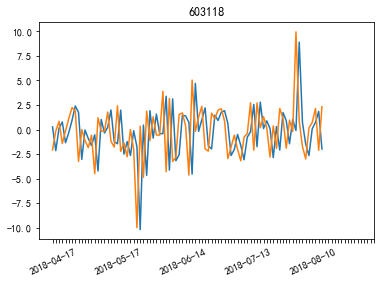

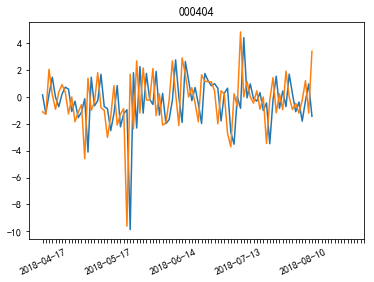

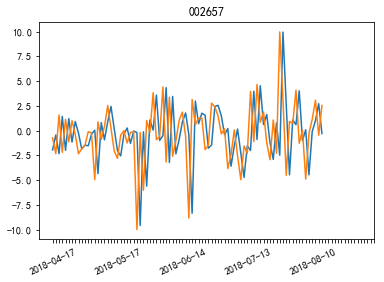

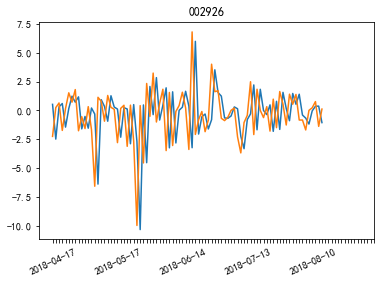

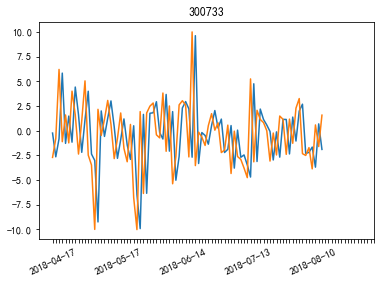

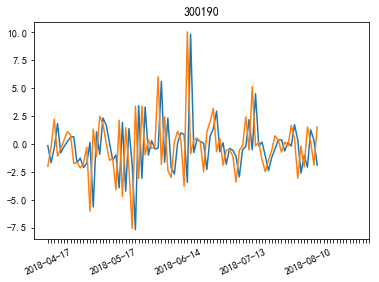

In [7]:

for key in stock_predict.keys():
    plt.figure(key)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    predict=stock_predict[key]

    pydate_array = stock_data1[key].keys().to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    my_x = pd.Series(date_only_array)


    new_x=[]
    for i in range(my_x.shape[0]):
        if i%20 != 0 :
            new_x.append('')
        else:new_x.append(my_x[i])
        

    ss = stock_data1[key].sort_index().dropna().values  
    plt.plot(predict)
    plt.plot(ss[look_back+1:])
    sss=range(100)
    plt.xticks(sss,new_x,rotation=25)
    plt.title(key)
    #plt.savefig(key,'.png')
    
    
    
    
    

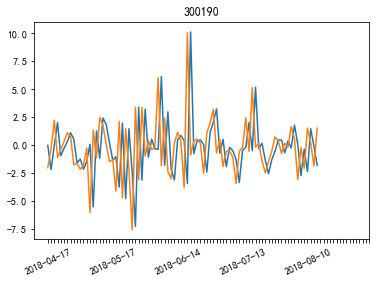

In [16]:
    key='300190'
    plt.figure(key)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    predict=stock_predict[key]

    pydate_array = stock_data1[key].keys().to_pydatetime()
    date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
    my_x = pd.Series(date_only_array)


    new_x=[]
    for i in range(my_x.shape[0]):
        if i%20 != 0 :
            new_x.append('')
        else:new_x.append(my_x[i])
        

    ss = stock_data1[key].sort_index().dropna().values  
    plt.plot(predict)
    plt.plot(ss[look_back+1:])
    sss=range(100)
    plt.xticks(sss,new_x,rotation=25)
    plt.title(key)
    plt.savefig('300190.png')